In [1]:
import pandas as pd
import cupy as cp
import cubewalkers as cw
import matplotlib.pyplot as plt
from matplotlib.colors import CenteredNorm
from matplotlib.patches import Rectangle
%matplotlib inline

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
plt.rcParams.update({'font.size':20})

In [2]:
QCF = pd.read_csv('data/quasicoherence_fuzzy_withsource.csv')
QC = pd.read_csv('data/quasicoherence_nonfuzzy_withsource.csv')
QCFNS = pd.read_csv('data/quasicoherence_fuzzy_sourceless.csv')
QCNS = pd.read_csv('data/quasicoherence_nonfuzzy_sourceless.csv')
FHD = pd.read_csv('data/final_hamming_distance_withsource.csv')
FHDNS = pd.read_csv('data/final_hamming_distance_sourceless.csv')
DC = pd.read_csv('data/derrida_coefficients.csv')
QC = QC.merge(QCF)
QC = QC.merge(QCNS)
QC = QC.merge(QCFNS)
QC = QC.merge(FHD)
QC = QC.merge(FHDNS)
QC = QC.merge(DC)
QC.columns = ['name', 
              'SQC', 'AQC', 
              'SFQC', 'AFQC', 
              'SQCNS', 'AQCNS', 
              'SFQCNS', 'AFQCNS',
              'SFHD', 'AFHD', 
              'SFHDNS', 'AFHDNS',
              'SDC', 'ADC', 
              'SDCNS', 'ADCNS']



N = []
NS = []
for name in sorted(QC['name']):
    with open(f'models/cell_collective/{name}.txt') as f:
        nt = 0
        ns = 0
        for row in f:
            nt += 1
            if row.split(',')[0].strip() == row.split(',')[1].strip():
                ns += 1
        N.append(nt)
        NS.append(ns)

NDF = pd.DataFrame({
    'name': sorted(QC['name']),
    'N': N,
    'NS': NS,
})

QC=QC.merge(NDF)

# Fragility = 
# long-term difference in node avg. values after initial 1-node perturbation
QC['AF'] = (1-QC['AFQC'])*(QC['N'])
QC['SF'] = (1-QC['SFQC'])*(QC['N'])
QC['AFNS'] = (1-QC['AFQCNS'])*(QC['N']-QC['NS'])
QC['SFNS'] = (1-QC['SFQCNS'])*(QC['N']-QC['NS'])

QC.sort_values(by=['name'])

,name,SQC,AQC,SFQC,AFQC,SQCNS,AQCNS,SFQCNS,AFQCNS,SFHD,AFHD,SFHDNS,AFHDNS,SDC,ADC,SDCNS,ADCNS,N,NS,AF,SF,AFNS,SFNS
0,Apoptosis Network,0.901912,0.902156,0.975426,0.975390,0.948164,0.948421,0.988943,0.990378,1.437062,1.131135,0.814343,0.473098,1.00488,1.037920,0.928257,0.957248,41,2,1.009010,1.007534,0.375258,0.431223
1,Arabidopsis thaliana Cell Cycle,1.000000,0.917571,0.997661,0.972700,1.000000,0.917571,0.997661,0.972700,1.733368,0.764848,1.733368,0.764848,1.27225,1.215076,1.271043,1.227097,14,0,0.382200,0.032746,0.382200,0.032746
2,Aurora Kinase A in Neuroblastoma,0.761704,0.768922,0.942917,0.939552,0.922063,0.930800,0.958553,0.951182,1.832950,1.407045,1.359018,0.947297,1.04819,1.063182,0.991720,0.999190,23,4,1.390304,1.312909,0.927542,0.787493
3,B bronchiseptica and T retortaeformis coinfection,0.912491,0.924604,0.991398,0.988166,0.930038,0.942385,0.992952,0.990038,0.459389,0.627200,0.370019,0.518000,1.00127,0.996849,0.966009,0.967529,53,1,0.627202,0.455906,0.518024,0.366496
4,B cell differentiation,0.735073,0.738927,0.957423,0.955985,0.951271,0.956259,0.985727,0.987520,0.936691,0.968327,0.242635,0.212165,0.99674,1.019382,0.704322,0.747895,22,5,0.968330,0.936694,0.212160,0.242641
5,BT474 Breast Cell Line Long-term ErbB Network,0.621632,0.605120,0.973296,0.971596,0.817937,0.796211,0.985437,0.983033,0.667600,0.710112,0.276695,0.322379,0.94772,0.922200,0.803044,0.794584,25,6,0.710100,0.667600,0.322373,0.276697
6,BT474 Breast Cell Line Short-term ErbB Network,0.640175,0.603025,0.964353,0.958688,0.931164,0.877127,0.989177,0.983220,0.570350,0.661000,0.119055,0.184582,0.76086,0.826380,0.374177,0.553145,16,5,0.660992,0.570352,0.184580,0.119053
7,Bordetella bronchiseptica,0.971212,0.964376,0.993846,0.998152,0.971212,0.964376,0.993846,0.998152,0.204667,0.060968,0.204667,0.060968,1.01878,0.990579,1.013961,0.999820,33,0,0.060984,0.203082,0.060984,0.203082
8,Bortezomib Responses in U266 Human Myeloma Cells,0.924681,0.920478,0.991689,0.989051,0.999252,0.994710,0.999633,0.997051,0.556860,0.733576,0.022731,0.182865,0.97716,1.008713,0.898823,0.935004,67,5,0.733583,0.556837,0.182838,0.022754
9,Budding Yeast Cell Cycle,0.719740,0.775640,0.951517,0.952787,0.899675,0.969550,0.985736,0.991275,1.072015,0.956479,0.339693,0.154869,1.01413,1.019960,0.825870,0.865000,20,4,0.944260,0.969660,0.139600,0.228224


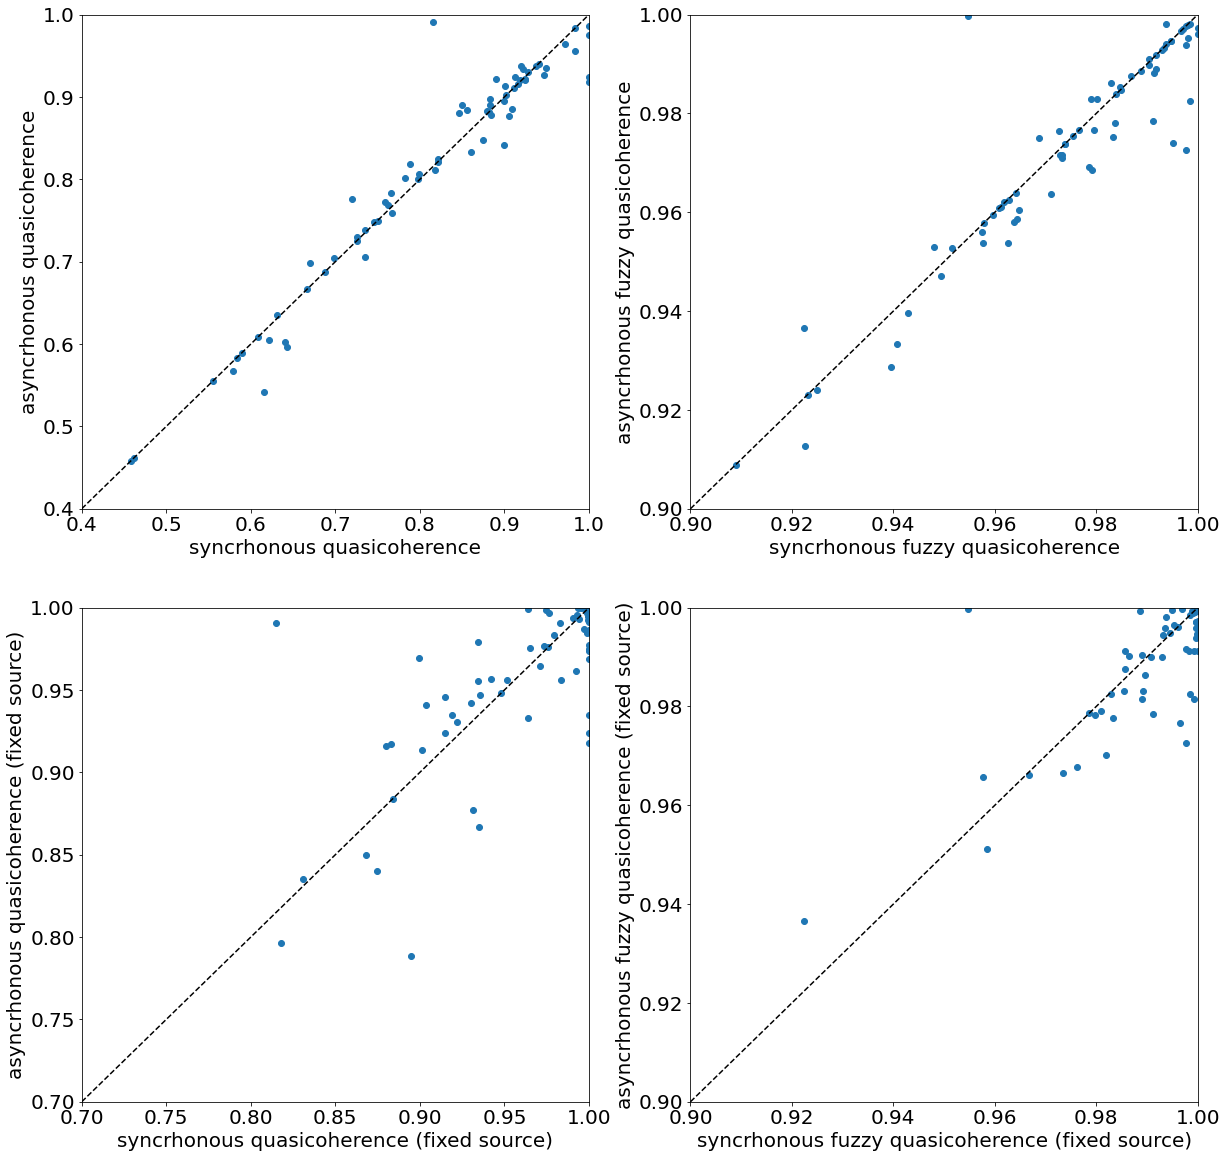

In [12]:
fig,ax = plt.subplots(2,2,figsize=(20,20))
fig.set_facecolor('white')

ax[0,0].scatter(QC['SQC'],QC['AQC'])
ax[0,0].set_xlabel('syncrhonous quasicoherence')
ax[0,0].set_ylabel('asyncrhonous quasicoherence')
ax[0,0].set_xlim(0.4,1)
ax[0,0].set_ylim(0.4,1)

ax[0,1].scatter(QC['SFQC'],QC['AFQC'])
ax[0,1].set_xlabel('syncrhonous fuzzy quasicoherence')
ax[0,1].set_ylabel('asyncrhonous fuzzy quasicoherence')
ax[0,1].set_xlim(0.9,1)
ax[0,1].set_ylim(0.9,1)

ax[1,0].scatter(QC['SQCNS'],QC['AQCNS'])
ax[1,0].set_xlabel('syncrhonous quasicoherence (fixed source)')
ax[1,0].set_ylabel('asyncrhonous quasicoherence (fixed source)')
ax[1,0].set_xlim(0.7,1)
ax[1,0].set_ylim(0.7,1)

ax[1,1].scatter(QC['SFQCNS'],QC['AFQCNS'])
ax[1,1].set_xlabel('syncrhonous fuzzy quasicoherence (fixed source)')
ax[1,1].set_ylabel('asyncrhonous fuzzy quasicoherence (fixed source)')
ax[1,1].set_xlim(0.9,1)
ax[1,1].set_ylim(0.9,1)

for sub_ax in ax.flatten():
    sub_ax.axline((1,1),slope=1,linestyle='--',color='k')

plt.savefig('./figures/quasicoherence_comparisons.png')
plt.savefig('./figures/quasicoherence_comparisons.pdf')
plt.show()

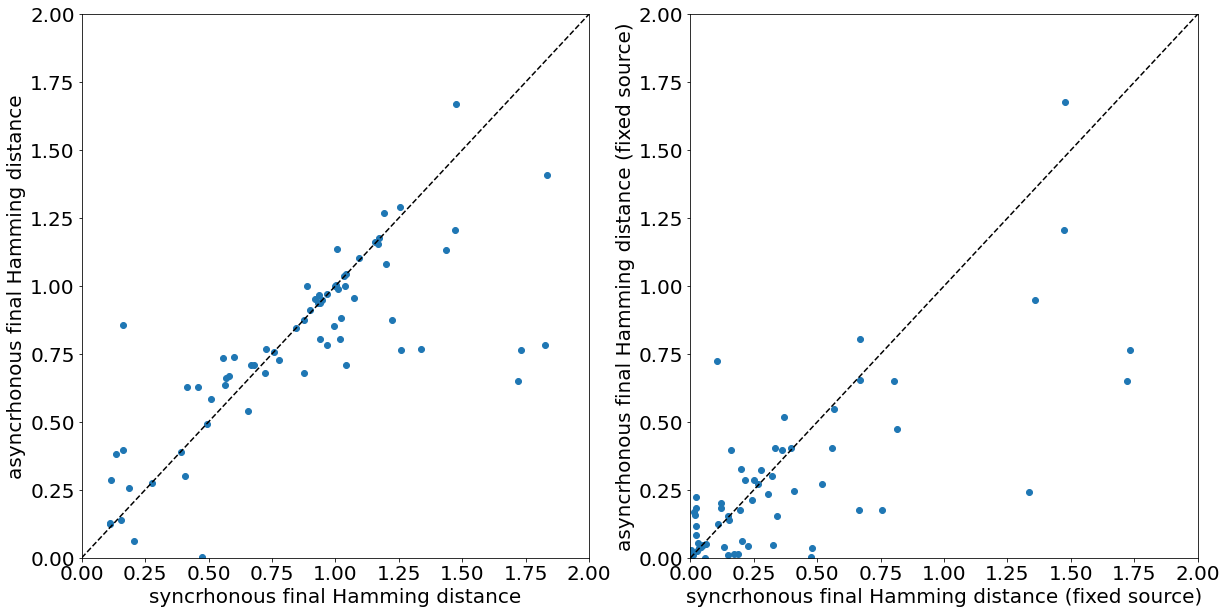

In [16]:
fig,ax = plt.subplots(1,2,figsize=(20,10))
fig.set_facecolor('white')

ax[0].scatter(QC['SFHD'],QC['AFHD'])
ax[0].set_xlabel('syncrhonous final Hamming distance')
ax[0].set_ylabel('asyncrhonous final Hamming distance')
ax[0].set_xlim(0,2)
ax[0].set_ylim(0,2)
ax[1].scatter(QC['SFHDNS'],QC['AFHDNS'])
ax[1].set_xlabel('syncrhonous final Hamming distance (fixed source)')
ax[1].set_ylabel('asyncrhonous final Hamming distance (fixed source)')
ax[1].set_xlim(0,2)
ax[1].set_ylim(0,2)

for sub_ax in ax.flatten():
    sub_ax.axline((1,1),slope=1,linestyle='--',color='k')


plt.savefig('./figures/Hamming_comparison.png')
plt.savefig('./figures/Hamming_comparison.pdf')
plt.show()

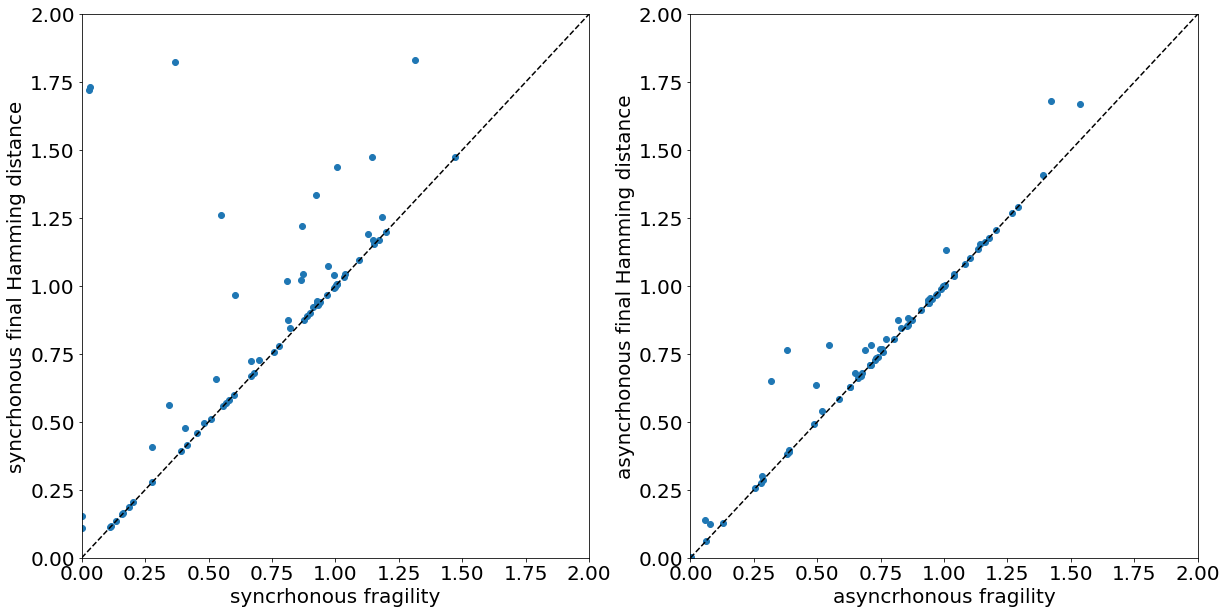

In [15]:
fig,ax = plt.subplots(1,2,figsize=(20,10))
fig.set_facecolor('white')

ax[0].scatter(QC['SF'],QC['SFHD'])
ax[0].set_xlabel('syncrhonous fragility')
ax[0].set_ylabel('syncrhonous final Hamming distance')
ax[0].set_xlim(0,2)
ax[0].set_ylim(0,2)
ax[1].scatter(QC['AF'],QC['AFHD'])
ax[1].set_xlabel('asyncrhonous fragility')
ax[1].set_ylabel('asyncrhonous final Hamming distance')
ax[1].set_xlim(0,2)
ax[1].set_ylim(0,2)

for sub_ax in ax.flatten():
    sub_ax.axline((1,1),slope=1,linestyle='--',color='k')

plt.savefig('./figures/Hamming-Fragility.png')
plt.savefig('./figures/Hamming-Fragility.pdf')
plt.show()

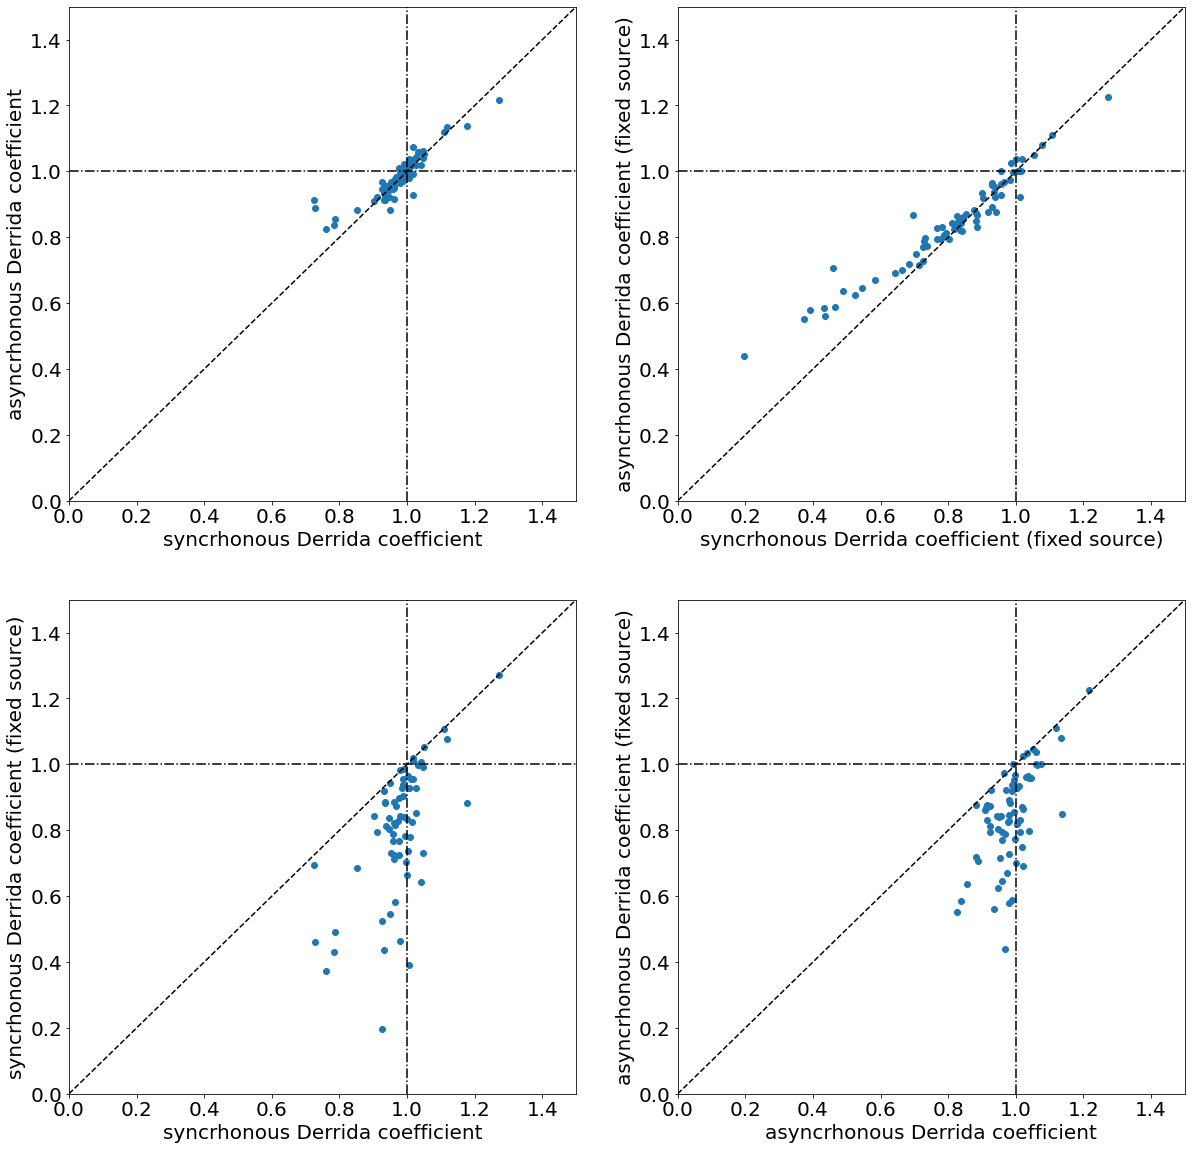

In [17]:
fig,ax = plt.subplots(2,2,figsize=(20,20))
fig.set_facecolor('white')

ax[0,0].scatter(QC['SDC'],QC['ADC'])
ax[0,0].set_xlabel('syncrhonous Derrida coefficient')
ax[0,0].set_ylabel('asyncrhonous Derrida coefficient')
ax[0,0].set_xlim(0,1.5)
ax[0,0].set_ylim(0,1.5)

ax[0,1].scatter(QC['SDCNS'],QC['ADCNS'])
ax[0,1].set_xlabel('syncrhonous Derrida coefficient (fixed source)')
ax[0,1].set_ylabel('asyncrhonous Derrida coefficient (fixed source)')
ax[0,1].set_xlim(0,1.5)
ax[0,1].set_ylim(0,1.5)

ax[1,0].scatter(QC['SDC'],QC['SDCNS'])
ax[1,0].set_xlabel('syncrhonous Derrida coefficient')
ax[1,0].set_ylabel('syncrhonous Derrida coefficient (fixed source)')
ax[1,0].set_xlim(0,1.5)
ax[1,0].set_ylim(0,1.5)

ax[1,1].scatter(QC['ADC'],QC['ADCNS'])
ax[1,1].set_xlabel('asyncrhonous Derrida coefficient')
ax[1,1].set_ylabel('asyncrhonous Derrida coefficient (fixed source)')
ax[1,1].set_xlim(0,1.5)
ax[1,1].set_ylim(0,1.5)

for sub_ax in ax.flatten():
    sub_ax.axline((1,1),slope=1,linestyle='--',color='k')
    sub_ax.hlines(1,0,1.5,linestyle='-.',color='k')
    sub_ax.vlines(1,0,1.5,linestyle='-.',color='k')

plt.savefig('./figures/Derrida_comparison.png')
plt.savefig('./figures/Derrida_comparison.pdf')
plt.show()

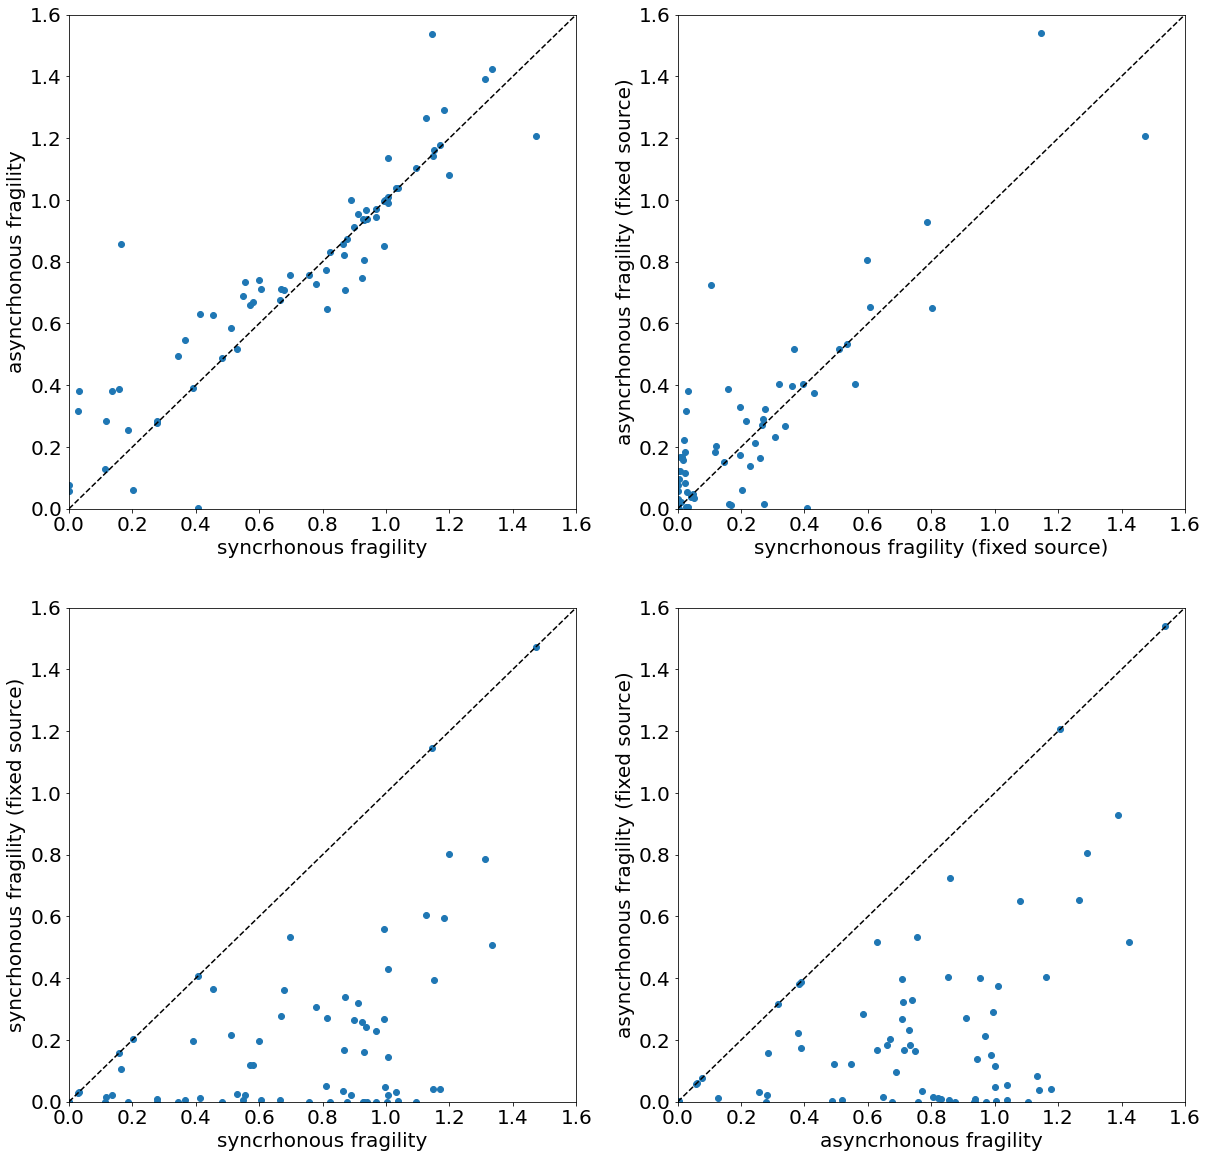

In [18]:
fig,ax = plt.subplots(2,2,figsize=(20,20))
fig.set_facecolor('white')

ax[0,0].scatter(QC['SF'],QC['AF'])
ax[0,0].set_xlabel('syncrhonous fragility')
ax[0,0].set_ylabel('asyncrhonous fragility')
ax[0,0].set_xlim(0,1.6)
ax[0,0].set_ylim(0,1.6)

ax[0,1].scatter(QC['SFNS'],QC['AFNS'])
ax[0,1].set_xlabel('syncrhonous fragility (fixed source)')
ax[0,1].set_ylabel('asyncrhonous fragility (fixed source)')
ax[0,1].set_xlim(0,1.6)
ax[0,1].set_ylim(0,1.6)

ax[1,0].scatter(QC['SF'],QC['SFNS'])
ax[1,0].set_xlabel('syncrhonous fragility')
ax[1,0].set_ylabel('syncrhonous fragility (fixed source)')
ax[1,0].set_xlim(0,1.6)
ax[1,0].set_ylim(0,1.6)

ax[1,1].scatter(QC['AF'],QC['AFNS'])
ax[1,1].set_xlabel('asyncrhonous fragility')
ax[1,1].set_ylabel('asyncrhonous fragility (fixed source)')
ax[1,1].set_xlim(0,1.6)
ax[1,1].set_ylim(0,1.6)

for sub_ax in ax.flatten():
    sub_ax.axline((1,1),slope=1,linestyle='--',color='k')

plt.savefig('./figures/fragility_comparison.png')
plt.savefig('./figures/fragility_comparison.pdf')
plt.show()

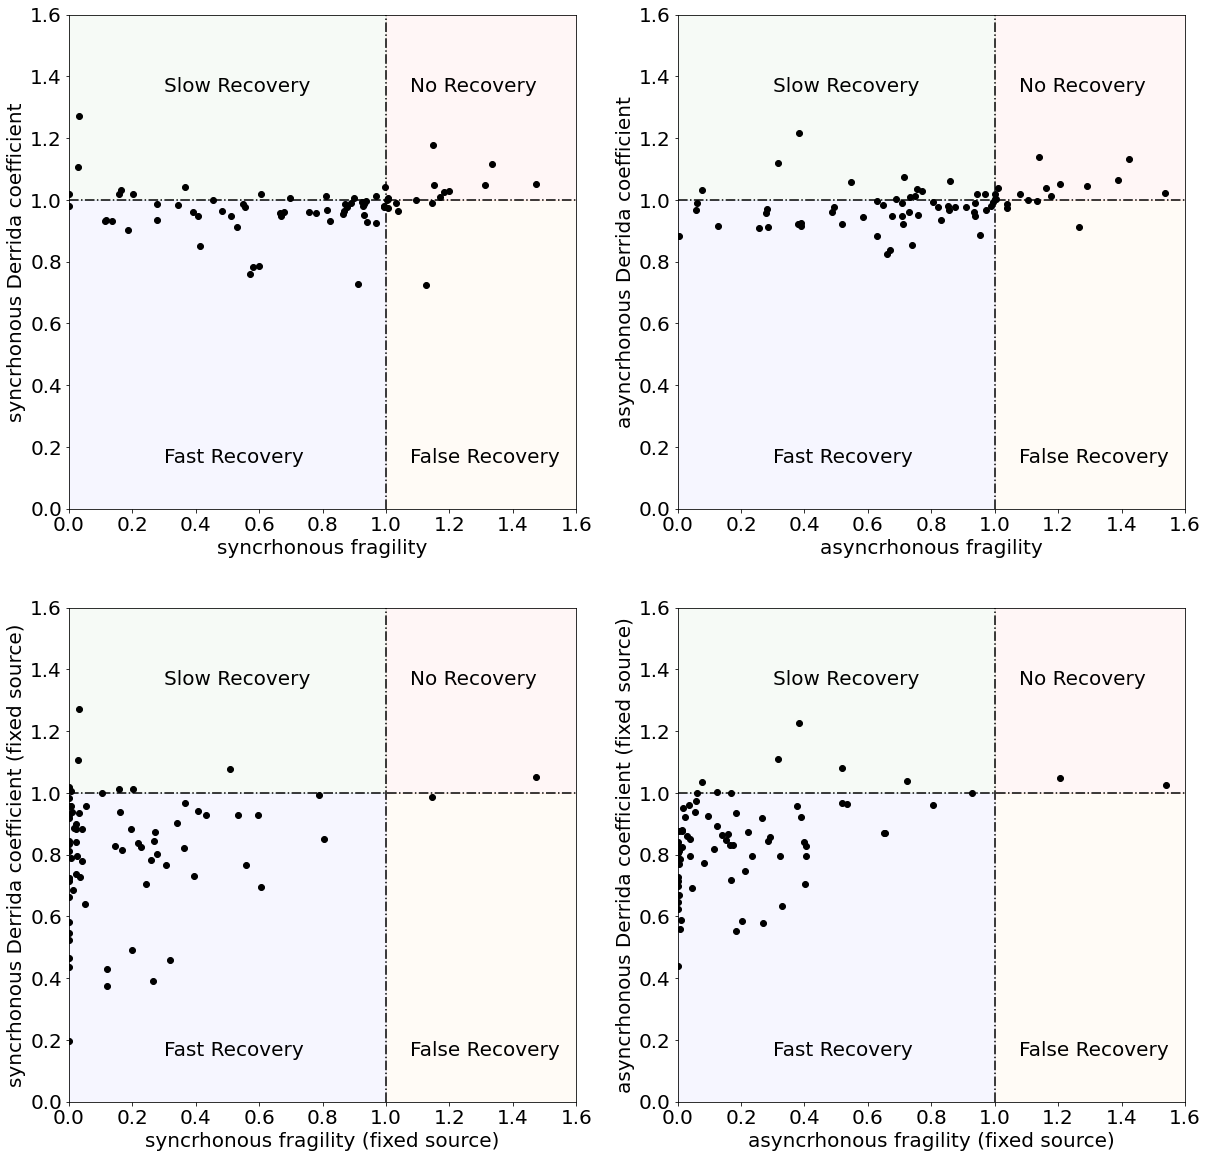

In [19]:
region_alpha = 0.035
cmap = plt.cm.get_cmap('coolwarm')
maxval = 1.6
cnorm=CenteredNorm(vcenter=0,halfrange=0.5)
fig,ax = plt.subplots(2,2,figsize=(20,20))
fig.set_facecolor('white')

for sub_ax in ax.flatten():
    regions = [
        Rectangle((0,0),1,1,color='blue',alpha=region_alpha),
        Rectangle((1,1),maxval-1,maxval-1,color='red',alpha=region_alpha),
        Rectangle((0,1),1,maxval-1,color='green',alpha=region_alpha),
        Rectangle((1,0),maxval-1,1,color='orange',alpha=region_alpha),
        ]
    
    #sub_ax.axline((1,1),slope=1,linestyle='--',color='k')
    sub_ax.hlines(1,0,maxval,linestyle='-.',color='k')
    sub_ax.vlines(1,0,maxval,linestyle='-.',color='k')
    [sub_ax.add_patch(r) for r in regions]
    sub_ax.annotate('Slow Recovery',xy=(0.3,1.35))
    sub_ax.annotate('Fast Recovery',xy=(0.3,0.15))
    sub_ax.annotate('False Recovery',xy=(1.075,0.15))
    sub_ax.annotate('No Recovery',xy=(1.075,1.35))

ax[0,0].scatter(QC['SF'],QC['SDC'],
                c='k')#c=QC['SF']-QC['SDC'],cmap=cmap, norm=cnorm)
ax[0,0].set_xlabel('syncrhonous fragility')
ax[0,0].set_ylabel('syncrhonous Derrida coefficient')
ax[0,0].set_xlim(0,maxval)
ax[0,0].set_ylim(0,maxval)

ax[0,1].scatter(QC['AF'],QC['ADC'],
                c='k')#c=QC['AF']-QC['ADC'],cmap=cmap, norm=cnorm)
ax[0,1].set_xlabel('asyncrhonous fragility')
ax[0,1].set_ylabel('asyncrhonous Derrida coefficient')
ax[0,1].set_xlim(0,maxval)
ax[0,1].set_ylim(0,maxval)

ax[1,0].scatter(QC['SFNS'],QC['SDCNS'],
                c='k')#c=QC['SFNS']-QC['SDCNS'],cmap=cmap, norm=cnorm)
ax[1,0].set_xlabel('syncrhonous fragility (fixed source)')
ax[1,0].set_ylabel('syncrhonous Derrida coefficient (fixed source)')
ax[1,0].set_xlim(0,maxval)
ax[1,0].set_ylim(0,maxval)

ax[1,1].scatter(QC['AFNS'],QC['ADCNS'],
                c='k')#c=QC['AFNS']-QC['ADCNS'],cmap=cmap, norm=cnorm)
ax[1,1].set_xlabel('asyncrhonous fragility (fixed source)')
ax[1,1].set_ylabel('asyncrhonous Derrida coefficient (fixed source)')
ax[1,1].set_xlim(0,maxval)
ax[1,1].set_ylim(0,maxval)



plt.savefig('./figures/Derrida-Fragility.png')
plt.savefig('./figures/Derrida-Fragility.pdf')
plt.show()